In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import argparse
import itertools
import json
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

from sklearn.metrics import confusion_matrix

In [3]:
pd.options.display.max_rows = 999

In [4]:
def get_confusion_matrix(json_files, is_fine=False, all_label_sets_ordered=None):
    results_dicts = []
    for json_file in json_files:
        with open(json_file, 'r') as json_data:
            results_dicts.append(json.load(json_data))
    json_gold_pred = "label_set_info (id/gold/pred)"
    json_gold_pred_fine = "id_gold_pred_fine"
    json_cm = 'confusion_matrix'
    if is_fine:
        json_gold_pred = json_gold_pred_fine
        json_cm += '_fine'
    id_gold_preds = []
    binary_confusion_matrix = np.zeros((6,2,2))
    for results_dict in results_dicts:
        id_gold_preds.append(results_dict[json_gold_pred])
        binary_confusion_matrix += np.array(results_dict[json_cm])
    
    n_rows = 3
    n_cols = 2
    n_classes = 2
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 8))
    row_idx, col_idx = 0, 0
    for idx, cm in enumerate(binary_confusion_matrix):
        ax = axes[row_idx, col_idx]
        ax.set_title(class_labels[idx])
        #ax.set_ylabel('True')
        #ax.set_xlabel('Predicted')
        ax.imshow(cm, interpolation='nearest', cmap='Wistia')
        s = [['TN','FP'], ['FN', 'TP']]
        for i in range(2):
            for j in range(2):
                #ax.text(j,i, str(s[i][j])+"="+str(cm[i][j]))
                ax.text(j,i, str(cm[i][j])+"("+str((cm[i][j]/np.array(cm).sum(axis=1)*100)[i])[:4]+"%)")
        ax.set(xticks=np.arange(n_classes),
               yticks=np.arange(n_classes),
               xticklabels=[0,1],
               yticklabels=[0,1],
               ylabel="True label",
               xlabel="Predicted label")
        ax.grid(False)
        ax.set_ylim((n_classes - 0.5, -0.5))
        #plt.setp(ax.get_xticklabels(), rotation=xticks_rotation)
        # increment counters
        col_idx += 1
        if col_idx >= n_cols:
            col_idx = 0
            row_idx += 1
    fig.tight_layout()
    plt.show()
    doc_ids = []
    target_labels = []
    predicted_labels = []
    target_coarse_labels=[]
    predicted_coarse_labels=[]
    target_sets = []
    predicted_sets = []
    for id_gold_pred in id_gold_preds:
        doc_fold_ids = []
        target_fold_labels = []
        predicted_fold_labels = []
        target_coarse_fold_labels = []
        pred_coarse_fold_labels = []
        for doc_id, gold_set, pred_set in id_gold_pred:
            coarse_gold = []
            coarse_pred = []
            if gold_set[0] or gold_set[1]:
                coarse_gold.append(1)
            else:
                coarse_gold.append(0)
            if gold_set[2] or gold_set[3]:
                coarse_gold.append(1)
            else:
                coarse_gold.append(0)
            if gold_set[4] or gold_set[5]:
                coarse_gold.append(1)
            else:
                coarse_gold.append(0)
                
            if pred_set[0] or pred_set[1]:
                coarse_pred.append(1)
            else:
                coarse_pred.append(0)
            if pred_set[2] or pred_set[3]:
                coarse_pred.append(1)
            else:
                coarse_pred.append(0)
            if pred_set[4] or pred_set[5]:
                coarse_pred.append(1)
            else:
                coarse_pred.append(0)
            
            target_fold_labels.append(gold_set)
            predicted_fold_labels.append(pred_set)
            target_coarse_fold_labels.append(coarse_gold)
            pred_coarse_fold_labels.append(coarse_pred)
            target_sets.append(gold_set)
            predicted_sets.append(pred_set)
            
            doc_fold_ids.append([doc_id]*len(gold_set))
        target_labels.append(target_fold_labels)
        predicted_labels.append(predicted_fold_labels)
        
        target_coarse_labels.append(target_coarse_fold_labels)
        predicted_coarse_labels.append(pred_coarse_fold_labels)
        
        doc_ids.append(doc_fold_ids)
        
    target_sets = [''.join(map(str, target_label_set)) for target_label_set in target_sets]
    predicted_sets = [''.join(map(str, predicted_label_set)) for predicted_label_set in predicted_sets]
    
    if all_label_sets_ordered is None:
        s = pd.Series(target_sets)
        s.value_counts().plot(kind='bar')
        target_sets_ordered = s.value_counts().index.values
    
        missing_labels = set(predicted_sets).difference(set(target_sets_ordered))
        all_label_sets_ordered = np.append(target_sets_ordered,list(missing_labels))
    cm=confusion_matrix(target_sets, predicted_sets, labels=all_label_sets_ordered)
    
    plot_confusion_matrix(cm, all_label_sets_ordered, normalize=False)
    plt.show()
    return doc_ids, target_labels, predicted_labels, target_coarse_labels, predicted_coarse_labels, all_label_sets_ordered

In [5]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        text_color = "black"
        if i==j:
            text_color = "red"
        elif cm[i, j] > thresh:
            text_color = "white"
                
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color=text_color)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color=text_color)


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

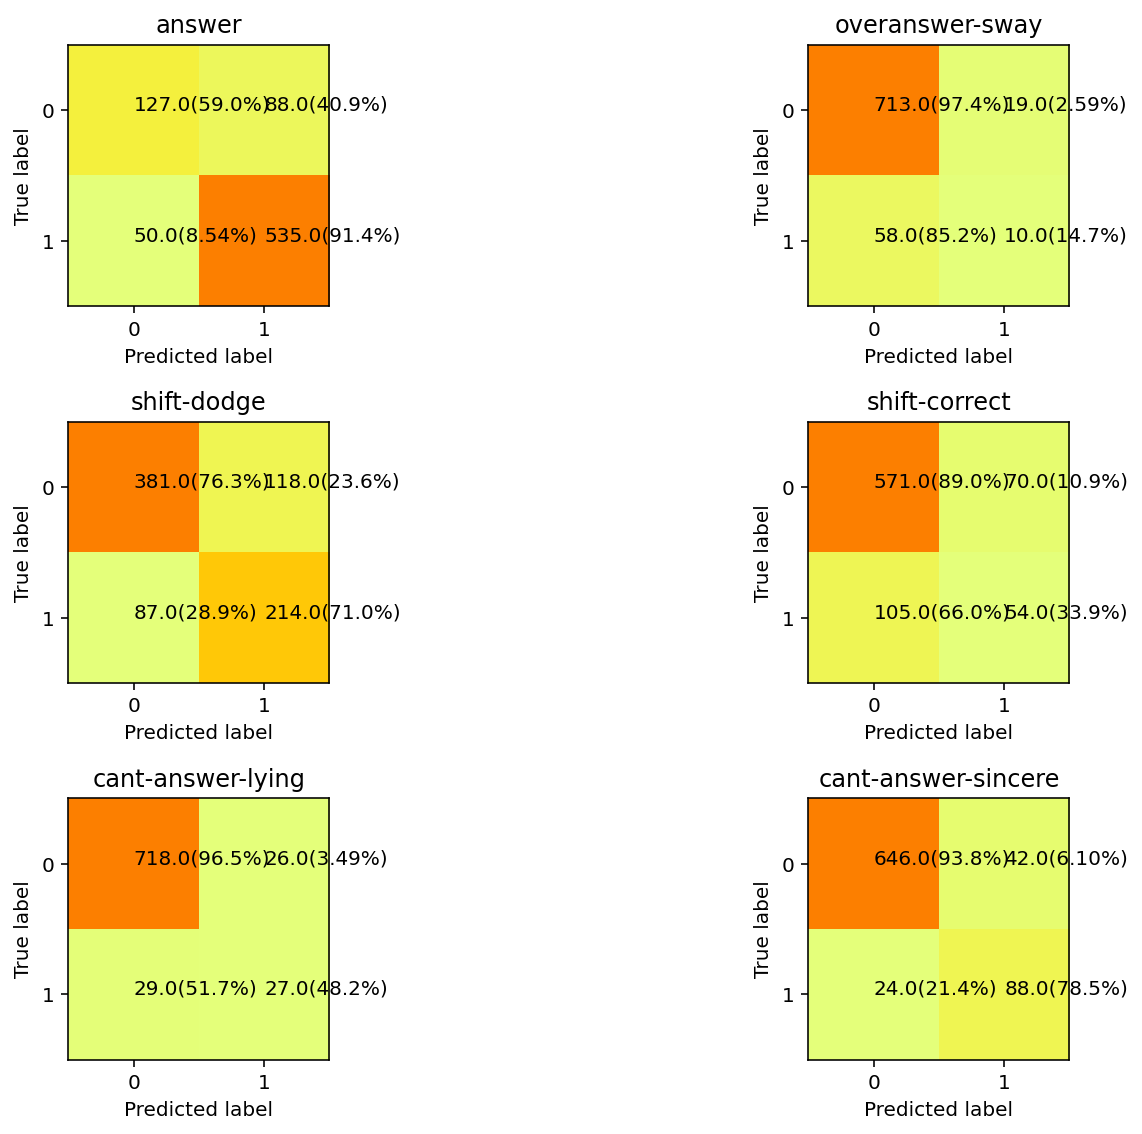

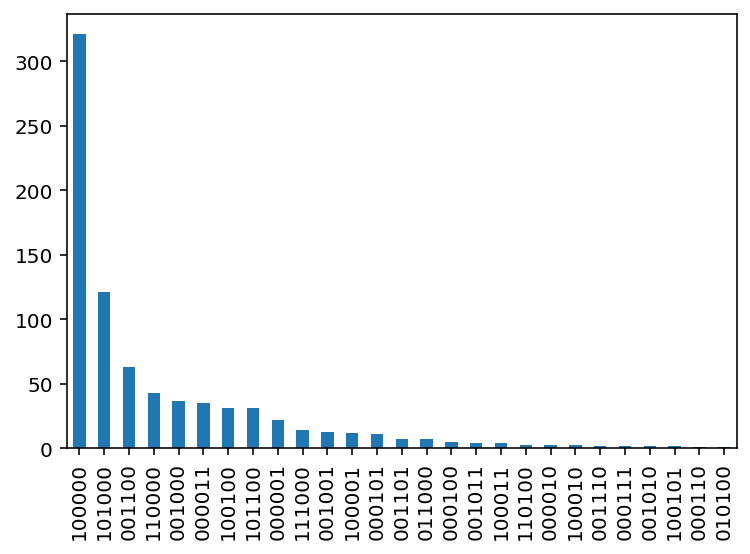

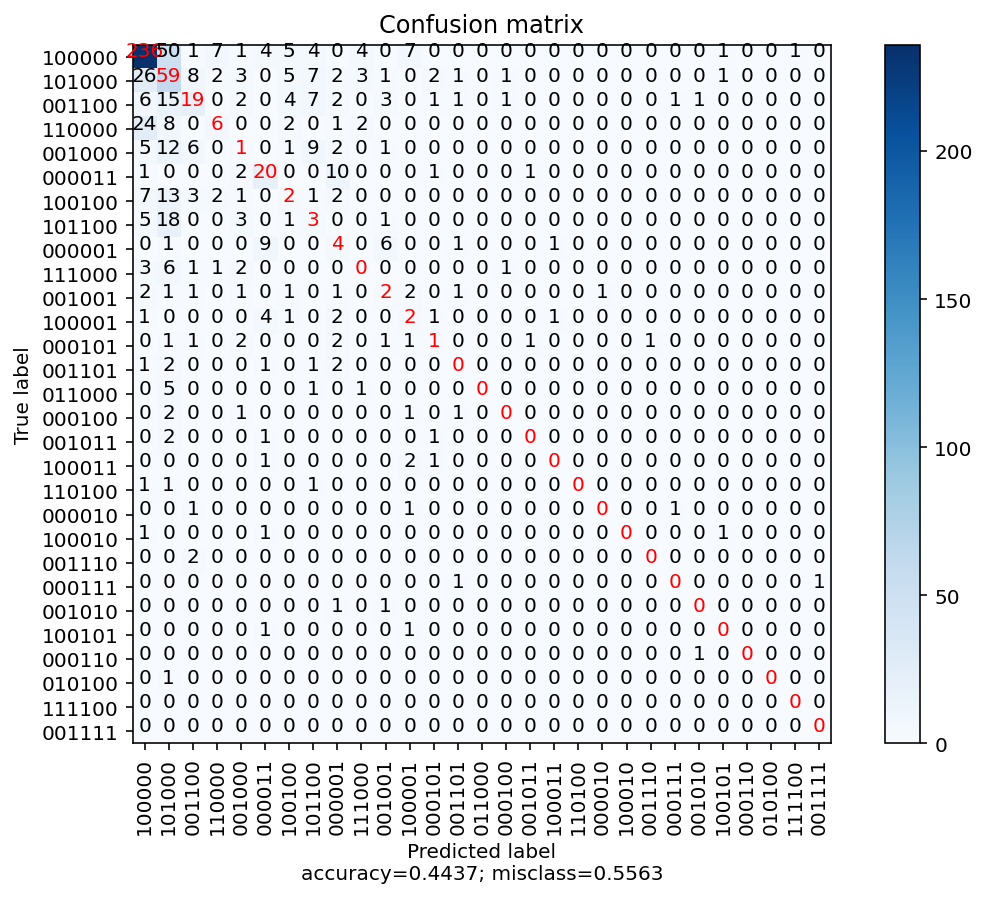

In [6]:
class_labels = ['answer', 'overanswer-sway', 
                'shift-dodge', 'shift-correct', 
                'cant-answer-lying','cant-answer-sincere']
base_files = []
for fold_num in range(4):
    base_files.append('/Users/elisa/Documents/CompLing/congressional_hearing/results/roberta_classification/roberta_test_context/1_input/metrics_roberta_classification_r_text_test.json_fold'+str(fold_num)+'_test')
base_ids, base_targets, base_preds, base_coarse_targets, base_coarse_preds, base_targets_ordered = get_confusion_matrix(base_files)

In [7]:
all_class_labels = []
all_base_ids = []
all_base_targets = []
all_base_preds = []
for fold in range(len(base_ids)):
    all_class_labels.append(class_labels*(len(base_ids[fold])))
    all_base_ids.append(list(itertools.chain.from_iterable(base_ids[fold])))
    all_base_targets.append(list(itertools.chain.from_iterable(base_targets[fold])))
    all_base_preds.append(list(itertools.chain.from_iterable(base_preds[fold])))
base_dfs=[]
for fold in range(len(base_ids)):
    base_dfs.append(pd.DataFrame(zip(all_class_labels[fold], all_base_ids[fold], all_base_targets[fold], all_base_preds[fold]), columns=['label','qa_index','gold','pred']))
    base_dfs[fold]['correct'] = base_dfs[fold]['gold']==base_dfs[fold]['pred']
    base_dfs[fold]['uid'] = base_dfs[fold]['label']+'_'+base_dfs[fold]['qa_index'].astype(str)

In [8]:
incorrect_base_qas=[]
for fold in range(4):
    incorrect_base_qas.extend(base_dfs[fold][base_dfs[fold]['correct']==False]['qa_index'].values)

In [9]:
f1_scores = []
for fold_targets, fold_preds in zip(base_targets, base_preds):
    f1_scores.append(metrics.f1_score(fold_targets, fold_preds, average='macro'))
np.mean(np.array(f1_scores))

0.5503622703321143

In [10]:
f1_class_scores = []
for fold_targets, fold_preds in zip(base_targets, base_preds):
    f1_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_class_scores)).mean(axis=0)

array([0.88375563, 0.1816067 , 0.66623946, 0.3612356 , 0.47898154,
       0.73035469])

In [11]:
f1_coarse_class_scores = []
for fold_targets, fold_preds in zip(base_coarse_targets, base_coarse_preds):
    f1_coarse_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_coarse_class_scores)).mean(axis=0)

array([0.8910741 , 0.74451078, 0.76211673])

### Hierarchical

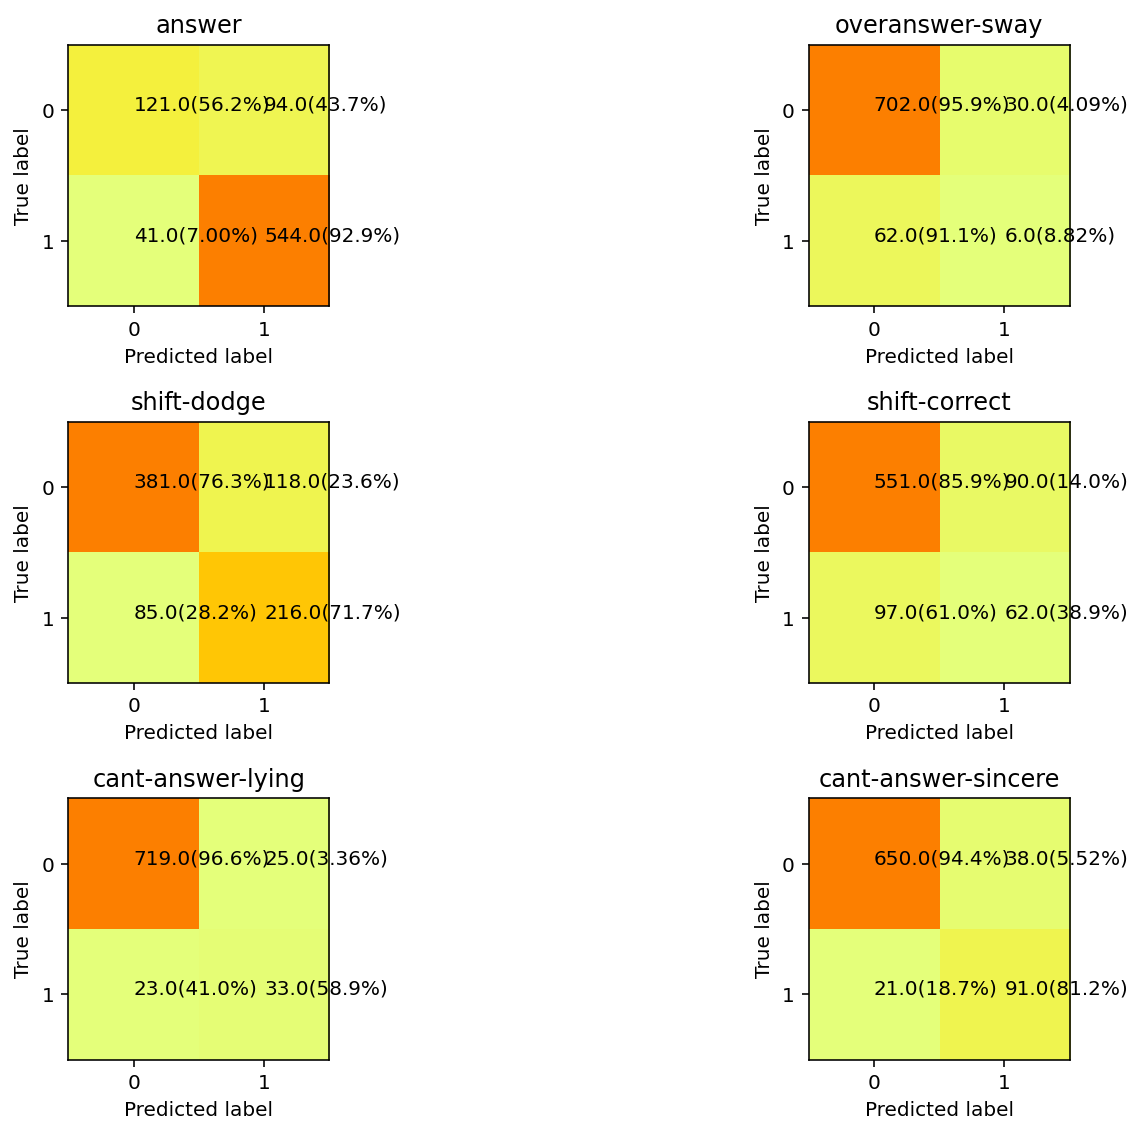

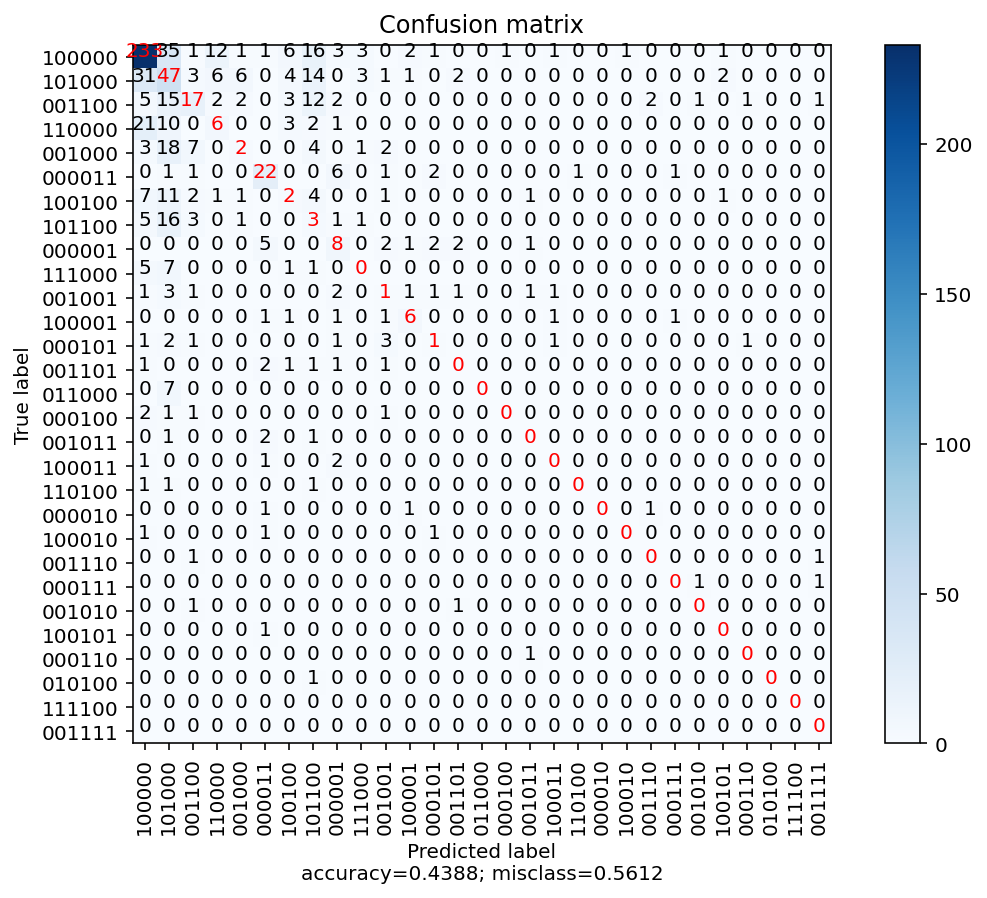

In [12]:
hier_files = []
for fold_num in range(4):
    hier_files.append('/Users/elisa/Documents/CompLing/congressional_hearing/results/roberta_classification/roberta_test_hier/1_input/metrics_roberta_hierarchical_r_text_test.json_fold'+str(fold_num)+'_test_fine')
hier_ids, hier_targets, hier_preds, hier_coarse_targets, hier_coarse_preds, _ = get_confusion_matrix(hier_files, is_fine=True, all_label_sets_ordered=base_targets_ordered)

In [13]:
f1_class_scores = []
for fold_targets, fold_preds in zip(hier_targets, hier_preds):
    f1_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_class_scores)).mean(axis=0)

array([0.88841993, 0.11828704, 0.67610619, 0.3738656 , 0.56610035,
       0.77077617])

In [14]:
f1_coarse_class_scores = []
for fold_targets, fold_preds in zip(hier_coarse_targets, hier_coarse_preds):
    f1_coarse_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_coarse_class_scores)).mean(axis=0)

array([0.89556373, 0.73538359, 0.79073062])

In [15]:
all_class_labels = []
all_hier_ids = []
all_hier_targets = []
all_hier_preds = []
for fold in range(len(hier_ids)):
    all_class_labels.append(class_labels*(len(hier_ids[fold])))
    all_hier_ids.append(list(itertools.chain.from_iterable(hier_ids[fold])))
    all_hier_targets.append(list(itertools.chain.from_iterable(hier_targets[fold])))
    all_hier_preds.append(list(itertools.chain.from_iterable(hier_preds[fold])))
hier_dfs = []
for fold in range(len(hier_ids)):
    hier_dfs.append(pd.DataFrame(zip(all_class_labels[fold], all_hier_ids[fold], all_hier_targets[fold], all_hier_preds[fold]), columns=['label','qa_index','gold','pred']))
    hier_dfs[fold]['correct'] = hier_dfs[fold]['gold']==hier_dfs[fold]['pred']
    hier_dfs[fold]['uid'] = hier_dfs[fold]['label']+'_'+hier_dfs[fold]['qa_index'].astype(str)
merged_hier_dfs = []
for fold in range(len(hier_dfs)):
    merged_hier_dfs.append(base_dfs[fold].merge(hier_dfs[fold], on='uid',suffixes=('_base', '_hier')))

In [16]:
for fold in range(len(merged_hier_dfs)):
    print('Fold', fold)
    merged_hier_dfs[fold]['hearing_id'] = merged_hier_dfs[fold]['qa_index_base'].astype(str).str[:8]
    display(merged_hier_dfs[fold][(merged_hier_dfs[fold]['correct_base']==False) & (merged_hier_dfs[fold]['correct_hier']==True)]['hearing_id'].value_counts())
    display(merged_hier_dfs[fold][(merged_hier_dfs[fold]['correct_base']==False) & (merged_hier_dfs[fold]['correct_hier']==True)]['label_base'].value_counts())

Fold 0


11635589    17
11422125    12
11531417    11
11389598     7
Name: hearing_id, dtype: int64

shift-dodge            16
answer                 11
shift-correct           8
overanswer-sway         5
cant-answer-lying       4
cant-answer-sincere     3
Name: label_base, dtype: int64

Fold 1


11531504    11
11386195    10
11637282    10
11495063    10
Name: hearing_id, dtype: int64

shift-dodge            14
shift-correct          12
cant-answer-lying       5
cant-answer-sincere     5
overanswer-sway         3
answer                  2
Name: label_base, dtype: int64

Fold 2


11420722    20
11426003    15
11497630    14
11525545    12
Name: hearing_id, dtype: int64

shift-dodge            19
shift-correct          14
answer                 11
cant-answer-sincere     8
cant-answer-lying       6
overanswer-sway         3
Name: label_base, dtype: int64

Fold 3


11530956    13
11388494    12
11393834    12
11635230    11
Name: hearing_id, dtype: int64

shift-dodge            12
shift-correct          11
answer                  9
cant-answer-lying       6
overanswer-sway         5
cant-answer-sincere     5
Name: label_base, dtype: int64

In [17]:
for fold in range(4):
    print('Fold', fold)
    display(merged_hier_dfs[fold][(merged_hier_dfs[fold]['label_base']=='cant-answer-sincere')&(merged_hier_dfs[fold]['correct_base']==False) & (merged_hier_dfs[fold]['correct_hier']==True)])

Fold 0


,label_base,qa_index_base,gold_base,pred_base,correct_base,uid,label_hier,qa_index_hier,gold_hier,pred_hier,correct_hier,hearing_id
5,cant-answer-sincere,11635589093,1,0,False,cant-answer-sincere_11635589093,cant-answer-sincere,11635589093,1,1,True,11635589
887,cant-answer-sincere,11635589161,1,0,False,cant-answer-sincere_11635589161,cant-answer-sincere,11635589161,1,1,True,11635589
1019,cant-answer-sincere,11422125030,1,0,False,cant-answer-sincere_11422125030,cant-answer-sincere,11422125030,1,1,True,11422125


Fold 1


,label_base,qa_index_base,gold_base,pred_base,correct_base,uid,label_hier,qa_index_hier,gold_hier,pred_hier,correct_hier,hearing_id
5,cant-answer-sincere,11531504017,1,0,False,cant-answer-sincere_11531504017,cant-answer-sincere,11531504017,1,1,True,11531504
413,cant-answer-sincere,11495063021,0,1,False,cant-answer-sincere_11495063021,cant-answer-sincere,11495063021,0,0,True,11495063
533,cant-answer-sincere,11495063027,0,1,False,cant-answer-sincere_11495063027,cant-answer-sincere,11495063027,0,0,True,11495063
743,cant-answer-sincere,11637282128,0,1,False,cant-answer-sincere_11637282128,cant-answer-sincere,11637282128,0,0,True,11637282
1139,cant-answer-sincere,11386195006,0,1,False,cant-answer-sincere_11386195006,cant-answer-sincere,11386195006,0,0,True,11386195


Fold 2


,label_base,qa_index_base,gold_base,pred_base,correct_base,uid,label_hier,qa_index_hier,gold_hier,pred_hier,correct_hier,hearing_id
287,cant-answer-sincere,11420722016,0,1,False,cant-answer-sincere_11420722016,cant-answer-sincere,11420722016,0,0,True,11420722
449,cant-answer-sincere,11497630016,0,1,False,cant-answer-sincere_11497630016,cant-answer-sincere,11497630016,0,0,True,11497630
509,cant-answer-sincere,11420722014,0,1,False,cant-answer-sincere_11420722014,cant-answer-sincere,11420722014,0,0,True,11420722
515,cant-answer-sincere,11497630110,0,1,False,cant-answer-sincere_11497630110,cant-answer-sincere,11497630110,0,0,True,11497630
893,cant-answer-sincere,11420722074,0,1,False,cant-answer-sincere_11420722074,cant-answer-sincere,11420722074,0,0,True,11420722
1073,cant-answer-sincere,11525545053,1,0,False,cant-answer-sincere_11525545053,cant-answer-sincere,11525545053,1,1,True,11525545
1157,cant-answer-sincere,11426003006,0,1,False,cant-answer-sincere_11426003006,cant-answer-sincere,11426003006,0,0,True,11426003
1199,cant-answer-sincere,11525545152,1,0,False,cant-answer-sincere_11525545152,cant-answer-sincere,11525545152,1,1,True,11525545


Fold 3


,label_base,qa_index_base,gold_base,pred_base,correct_base,uid,label_hier,qa_index_hier,gold_hier,pred_hier,correct_hier,hearing_id
119,cant-answer-sincere,11388494137,0,1,False,cant-answer-sincere_11388494137,cant-answer-sincere,11388494137,0,0,True,11388494
755,cant-answer-sincere,11393834134,0,1,False,cant-answer-sincere_11393834134,cant-answer-sincere,11393834134,0,0,True,11393834
905,cant-answer-sincere,11635230113,1,0,False,cant-answer-sincere_11635230113,cant-answer-sincere,11635230113,1,1,True,11635230
1037,cant-answer-sincere,11393834040,1,0,False,cant-answer-sincere_11393834040,cant-answer-sincere,11393834040,1,1,True,11393834
1163,cant-answer-sincere,11388494117,0,1,False,cant-answer-sincere_11388494117,cant-answer-sincere,11388494117,0,0,True,11388494


In [ ]:
fold=2
merged_hier_dfs[fold][merged_hier_dfs[fold]['qa_index_hier']==11426003039]

In [ ]:
fold=3
merged_hier_dfs[fold][merged_hier_dfs[fold]['qa_index_hier']==11530956014]

### Last question

In [ ]:
last_q_files = []
for fold_num in range(4):
    last_q_files.append('/Users/elisa/Documents/CompLing/congressional_hearing/results/roberta_classification/roberta_test_hier/2_input/metrics_roberta_hierarchical_q_text_last_question_r_text_test.json_fold'+str(fold_num)+'_test_fine')
last_q_ids, last_q_targets, last_q_preds, last_q_coarse_targets, last_q_coarse_preds, _ = get_confusion_matrix(last_q_files, is_fine=True, all_label_sets_ordered=base_targets_ordered)

In [ ]:
f1_class_scores = []
for fold_targets, fold_preds in zip(last_q_targets, last_q_preds):
    f1_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_class_scores)).mean(axis=0)

In [ ]:
f1_coarse_class_scores = []
for fold_targets, fold_preds in zip(last_q_coarse_targets, last_q_coarse_preds):
    f1_coarse_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_coarse_class_scores)).mean(axis=0)

In [ ]:
all_class_labels = []
all_last_q_ids = []
all_last_q_targets = []
all_last_q_preds = []
for fold in range(len(last_q_ids)):
    all_class_labels.append(class_labels*(len(last_q_ids[fold])))
    all_last_q_ids.append(list(itertools.chain.from_iterable(last_q_ids[fold])))
    all_last_q_targets.append(list(itertools.chain.from_iterable(last_q_targets[fold])))
    all_last_q_preds.append(list(itertools.chain.from_iterable(last_q_preds[fold])))
last_q_dfs = []
for fold in range(len(last_q_ids)):
    last_q_dfs.append(pd.DataFrame(zip(all_class_labels[fold], all_last_q_ids[fold], all_last_q_targets[fold], all_last_q_preds[fold]), columns=['label','qa_index','gold','pred']))
    last_q_dfs[fold]['correct'] = last_q_dfs[fold]['gold']==last_q_dfs[fold]['pred']
    last_q_dfs[fold]['uid'] = last_q_dfs[fold]['label']+'_'+last_q_dfs[fold]['qa_index'].astype(str)
merged_last_q_dfs = []
for fold in range(len(last_q_dfs)):
    merged_last_q_dfs.append(hier_dfs[fold].merge(last_q_dfs[fold], on='uid',suffixes=('_hier_base', '_hier_last_q')))

In [ ]:
for fold in range(len(merged_last_q_dfs)):
    print('Fold', fold)
    merged_last_q_dfs[fold]['hearing_id'] = merged_last_q_dfs[fold]['qa_index_hier_base'].astype(str).str[:8]
    display(merged_last_q_dfs[fold][(merged_last_q_dfs[fold]['correct_hier_base']==False) & (merged_last_q_dfs[fold]['correct_hier_last_q']==True)]['hearing_id'].value_counts())
    display(merged_last_q_dfs[fold][(merged_last_q_dfs[fold]['correct_hier_base']==False) & (merged_last_q_dfs[fold]['correct_hier_last_q']==True)]['label_hier_base'].value_counts())

In [ ]:
fold=3
merged_last_q_dfs[fold][merged_last_q_dfs[fold]['qa_index_hier_base']==11530956014]

## Sentiment

In [ ]:
sent_files = []
for fold_num in range(4):
    sent_files.append('/Users/elisa/Documents/CompLing/congressional_hearing/results/roberta_classification/roberta_test_hier/2_input/metrics_roberta_hierarchical_gold_sentiments_coarse_num_r_text_test.json_fold'+str(fold_num)+'_test_fine')
sent_ids, sent_targets, sent_preds, sent_coarse_targets, sent_coarse_preds, _ = get_confusion_matrix(sent_files, is_fine=True, all_label_sets_ordered=base_targets_ordered)

In [ ]:
f1_class_scores = []
for fold_targets, fold_preds in zip(sent_targets, sent_preds):
    f1_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_class_scores)).mean(axis=0)

In [ ]:
f1_coarse_class_scores = []
for fold_targets, fold_preds in zip(hier_coarse_targets, hier_coarse_preds):
    f1_coarse_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_coarse_class_scores)).mean(axis=0)

In [ ]:
all_class_labels = []
all_sent_ids = []
all_sent_targets = []
all_sent_preds = []
for fold in range(len(sent_ids)):
    all_class_labels.append(class_labels*(len(sent_ids[fold])))
    all_sent_ids.append(list(itertools.chain.from_iterable(sent_ids[fold])))
    all_sent_targets.append(list(itertools.chain.from_iterable(sent_targets[fold])))
    all_sent_preds.append(list(itertools.chain.from_iterable(sent_preds[fold])))
sent_dfs = []
for fold in range(len(sent_ids)):
    sent_dfs.append(pd.DataFrame(zip(all_class_labels[fold], all_sent_ids[fold], all_sent_targets[fold], all_sent_preds[fold]), columns=['label','qa_index','gold','pred']))
    sent_dfs[fold]['correct'] = sent_dfs[fold]['gold']==sent_dfs[fold]['pred']
    sent_dfs[fold]['uid'] = sent_dfs[fold]['label']+'_'+sent_dfs[fold]['qa_index'].astype(str)
merged_sent_dfs = []
for fold in range(len(sent_dfs)):
    merged_sent_dfs.append(hier_dfs[fold].merge(sent_dfs[fold], on='uid',suffixes=('_hier_base', '_hier_sent')))

In [ ]:
for fold in range(len(merged_sent_dfs)):
    print('Fold', fold)
    merged_sent_dfs[fold]['hearing_id'] = merged_sent_dfs[fold]['qa_index_hier_base'].astype(str).str[:8]
    display(merged_sent_dfs[fold][(merged_sent_dfs[fold]['correct_hier_base']==False) & (merged_sent_dfs[fold]['correct_hier_sent']==True)]['hearing_id'].value_counts())
    display(merged_sent_dfs[fold][(merged_sent_dfs[fold]['correct_hier_base']==False) & (merged_sent_dfs[fold]['correct_hier_sent']==True)]['label_hier_base'].value_counts())

In [ ]:
fold=0
qa_indices = merged_sent_dfs[fold][(merged_sent_dfs[fold]['label_base']=='shift-dodge')&(merged_sent_dfs[fold]['correct_base']==False) & (merged_sent_dfs[fold]['correct_sent']==True)]['qa_index_base'].values

In [ ]:
merged_sent_dfs[fold][(merged_sent_dfs[fold]['qa_index_base'].isin(qa_indices))&(merged_sent_dfs[fold]['correct_base']==False)][['label_base','qa_index_base','gold_base','pred_base','pred_sent']]

In [ ]:
fold=3
merged_sent_dfs[fold][merged_sent_dfs[fold]['qa_index_hier_base']==11530956014]

## Sentiment+Last question

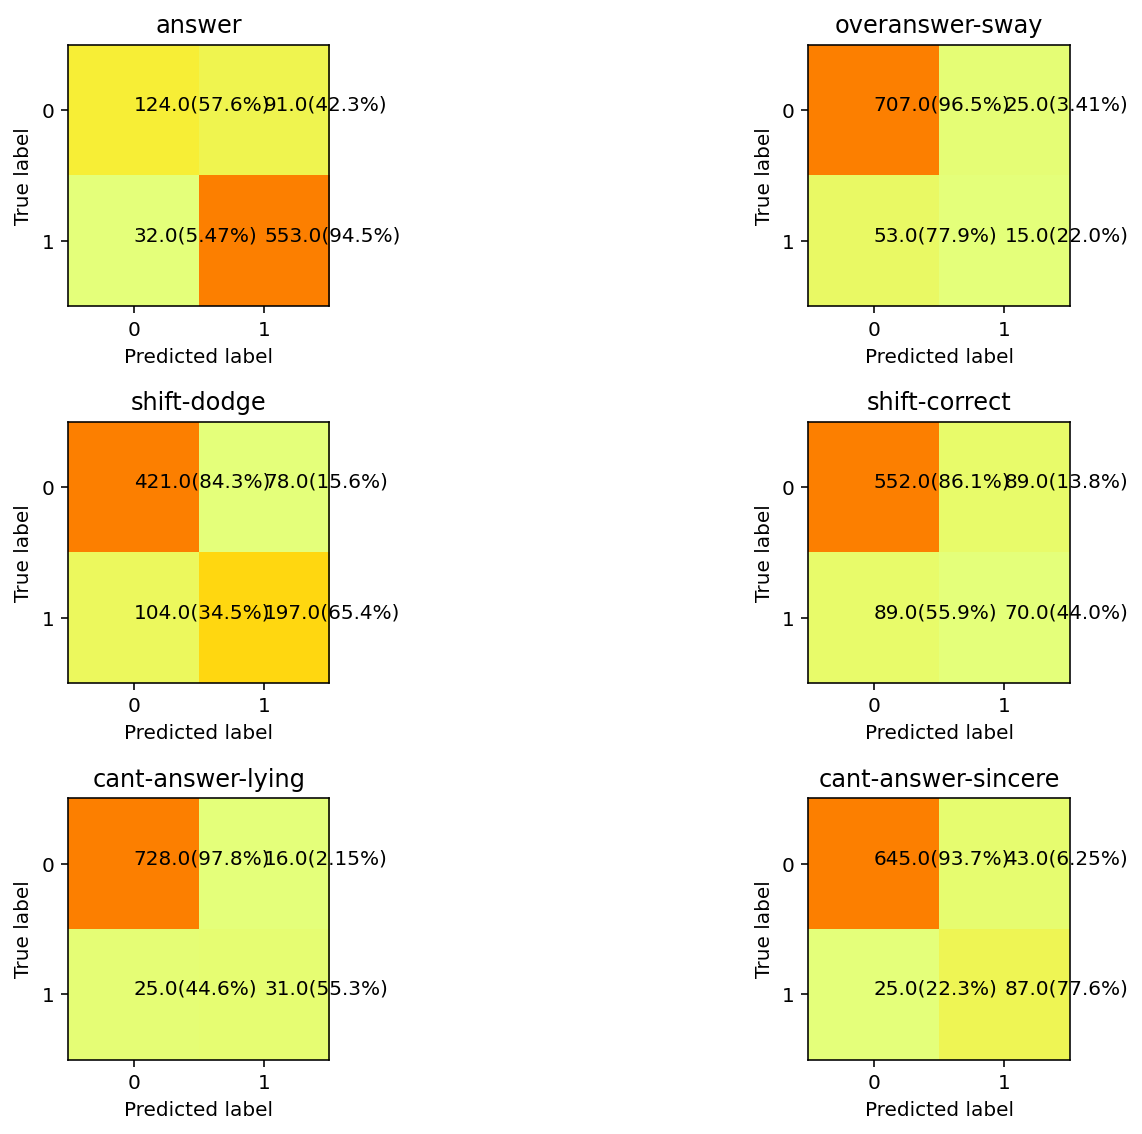

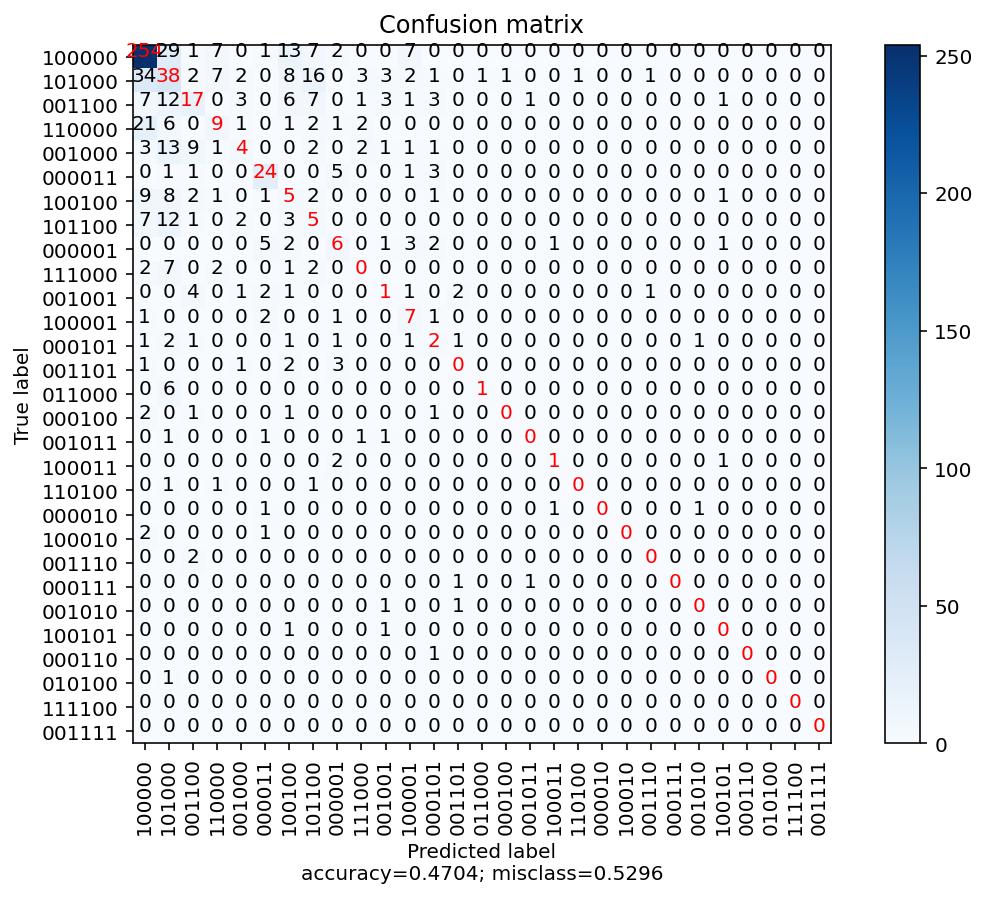

In [18]:
sent_quest_files = []
for fold_num in range(4):
    sent_quest_files.append('/Users/elisa/Documents/CompLing/congressional_hearing/results/roberta_classification/roberta_test_hier/3_input/metrics_roberta_hierarchical_r_text_gold_sentiments_coarse_num_q_text_last_question_test.json_fold'+str(fold_num)+'_test_fine')
sent_quest_ids, sent_quest_targets, sent_quest_preds, sent_quest_coarse_targets, sent_quest_coarse_preds, _ = get_confusion_matrix(sent_quest_files, is_fine=True, all_label_sets_ordered=base_targets_ordered)

In [19]:
all_class_labels = []
all_sent_quest_ids = []
all_sent_quest_targets = []
all_sent_quest_preds = []
for fold in range(len(sent_quest_ids)):
    all_class_labels.append(class_labels*(len(sent_quest_ids[fold])))
    all_sent_quest_ids.append(list(itertools.chain.from_iterable(sent_quest_ids[fold])))
    all_sent_quest_targets.append(list(itertools.chain.from_iterable(sent_quest_targets[fold])))
    all_sent_quest_preds.append(list(itertools.chain.from_iterable(sent_quest_preds[fold])))
sent_quest_dfs = []
for fold in range(len(sent_quest_ids)):
    sent_quest_dfs.append(pd.DataFrame(zip(all_class_labels[fold], all_sent_quest_ids[fold], all_sent_quest_targets[fold], all_sent_quest_preds[fold]), columns=['label','qa_index','gold','pred']))
    sent_quest_dfs[fold]['correct'] = sent_quest_dfs[fold]['gold']==sent_quest_dfs[fold]['pred']
    sent_quest_dfs[fold]['uid'] = sent_quest_dfs[fold]['label']+'_'+sent_quest_dfs[fold]['qa_index'].astype(str)
merged_sent_quest_dfs = []
for fold in range(len(sent_quest_dfs)):
    merged_sent_quest_dfs.append(hier_dfs[fold].merge(sent_quest_dfs[fold], on='uid',suffixes=('_hier_base', '_hier_sent_quest')))

In [20]:
for fold in range(len(merged_sent_quest_dfs)):
    print('Fold', fold)
    merged_sent_quest_dfs[fold]['hearing_id'] = merged_sent_quest_dfs[fold]['qa_index_hier_base'].astype(str).str[:8]
    display(merged_sent_quest_dfs[fold][(merged_sent_quest_dfs[fold]['correct_hier_base']==False) & (merged_sent_quest_dfs[fold]['correct_hier_sent_quest']==True)]['hearing_id'].value_counts())
    display(merged_sent_quest_dfs[fold][(merged_sent_quest_dfs[fold]['correct_hier_base']==False) & (merged_sent_quest_dfs[fold]['correct_hier_sent_quest']==True)]['label_hier_base'].value_counts())

Fold 0


11422125    30
11635589    22
11389598    15
11531417    12
Name: hearing_id, dtype: int64

shift-correct          22
shift-dodge            18
answer                 11
cant-answer-sincere    11
overanswer-sway         9
cant-answer-lying       8
Name: label_hier_base, dtype: int64

Fold 1


11386195    18
11531504    17
11495063    16
11637282     8
Name: hearing_id, dtype: int64

shift-dodge            17
shift-correct          17
cant-answer-lying      10
answer                 10
overanswer-sway         4
cant-answer-sincere     1
Name: label_hier_base, dtype: int64

Fold 2


11420722    24
11525545    19
11497630    18
11426003    17
Name: hearing_id, dtype: int64

shift-dodge            33
answer                 13
overanswer-sway        13
shift-correct           8
cant-answer-lying       6
cant-answer-sincere     5
Name: label_hier_base, dtype: int64

Fold 3


11393834    19
11530956    15
11388494    14
11635230    10
Name: hearing_id, dtype: int64

shift-correct          21
shift-dodge            20
overanswer-sway         9
answer                  6
cant-answer-lying       1
cant-answer-sincere     1
Name: label_hier_base, dtype: int64

In [23]:
corrected_sent_quest_qas=[]
all_sent_quest_qas=[]
for fold in range(4):
    corrected_sent_quest_qas.extend(merged_sent_quest_dfs[fold][(merged_sent_quest_dfs[fold]['correct_hier_base']==False) & (merged_sent_quest_dfs[fold]['correct_hier_sent_quest']==True)]['qa_index_hier_base'].values)
    all_sent_quest_qas.extend(merged_sent_quest_dfs[fold]['qa_index_hier_base'].values)

In [ ]:
corrected_sent_qas=[]
for fold in range(4):
    corrected_sent_qas.extend(merged_sent_dfs[fold][(merged_sent_dfs[fold]['correct_hier_base']==False) & (merged_sent_dfs[fold]['correct_hier_sent']==True)]['qa_index_hier_base'].values)

In [ ]:
corrected_hierarchical_qas=[]
for fold in range(4):
    corrected_hierarchical_qas.extend(merged_hier_dfs[fold][(merged_hier_dfs[fold]['correct_base']==False) & (merged_hier_dfs[fold]['correct_hier']==True)]['qa_index_hier'].values)

### Sent+quest vs Sent only

In [ ]:
merged_sent_quest_sent_dfs = []
for fold in range(len(sent_quest_dfs)):
    merged_sent_quest_sent_dfs.append(sent_dfs[fold].merge(sent_quest_dfs[fold], on='uid',suffixes=('_hier_sent', '_hier_sent_quest')))
for fold in range(len(merged_sent_quest_sent_dfs)):
    print('Fold', fold)
    merged_sent_quest_sent_dfs[fold]['hearing_id'] = merged_sent_quest_sent_dfs[fold]['qa_index_hier_sent'].astype(str).str[:8]
    display(merged_sent_quest_sent_dfs[fold][(merged_sent_quest_sent_dfs[fold]['correct_hier_sent']==False) & (merged_sent_quest_sent_dfs[fold]['correct_hier_sent_quest']==True)]['hearing_id'].value_counts())
    display(merged_sent_quest_sent_dfs[fold][(merged_sent_quest_sent_dfs[fold]['correct_hier_sent']==False) & (merged_sent_quest_sent_dfs[fold]['correct_hier_sent_quest']==True)]['label_hier_sent'].value_counts())

In [ ]:
fold=0
shift_correct_df = merged_sent_quest_sent_dfs[fold][(merged_sent_quest_sent_dfs[fold]['label_hier_sent']=='shift-correct')&(merged_sent_quest_sent_dfs[fold]['correct_hier_sent']==False) & (merged_sent_quest_sent_dfs[fold]['correct_hier_sent_quest']==True)][['label_hier_sent','qa_index_hier_sent','gold_hier_sent','pred_hier_sent','pred_hier_sent_quest','label_hier_sent_quest']]
shift_correct_df

In [ ]:
merged_sent_quest_sent_dfs[0][merged_sent_quest_sent_dfs[0]['qa_index_sent']==11531417008]

In [ ]:
qa=11426003041#11495063113#11426003004#11525545112
fold=2
merged_sent_quest_sent_dfs[fold][merged_sent_quest_sent_dfs[fold]['qa_index_sent']==qa][['label_sent','qa_index_sent','gold_sent','pred_sent','pred_sent_quest','label_sent_quest']]

In [ ]:
base_dfs[fold][base_dfs[fold]['qa_index']==qa]

In [ ]:
corrected_sent_quest_qas=[]
for fold in range(4):
    corrected_sent_quest_qas.extend(merged_sent_quest_sent_dfs[fold][(merged_sent_quest_sent_dfs[fold]['correct_hier_sent']==False) & (merged_sent_quest_sent_dfs[fold]['correct_hier_sent_quest']==True)]['qa_index_hier_sent'].values)

In [ ]:
(set(corrected_sent_quest_qas).intersection(set(corrected_sent_qas))).intersection(set(corrected_hierarchical_qas))#.intersection(set(incorrect_base_qas))

In [ ]:
set(corrected_hierarchical_qas)

In [ ]:
'11637282132'[-3:]

In [27]:
def qa_to_index(qa):
    qa = str(qa)
    congr = qa[:3]
    hrg = qa[3:8]
    qnum = qa[-3:]
    index = 'CHRG-'+congr+'hhrg'+hrg+'_'+qnum
    return index

In [29]:
corr_qas = []
all_qas = []
for qa in corrected_sent_quest_qas:
    corr_qas.append(qa_to_index(qa))
for qa in all_sent_quest_qas:
    all_qas.append(qa_to_index(qa))

In [35]:
set(corr_qas)

{'CHRG-113hhrg86195_002',
 'CHRG-113hhrg86195_008',
 'CHRG-113hhrg86195_018',
 'CHRG-113hhrg86195_028',
 'CHRG-113hhrg86195_032',
 'CHRG-113hhrg86195_036',
 'CHRG-113hhrg86195_040',
 'CHRG-113hhrg86195_049',
 'CHRG-113hhrg86195_060',
 'CHRG-113hhrg86195_072',
 'CHRG-113hhrg86195_080',
 'CHRG-113hhrg86195_084',
 'CHRG-113hhrg86195_094',
 'CHRG-113hhrg86195_098',
 'CHRG-113hhrg86195_104',
 'CHRG-113hhrg88494_041',
 'CHRG-113hhrg88494_060',
 'CHRG-113hhrg88494_112',
 'CHRG-113hhrg88494_114',
 'CHRG-113hhrg88494_119',
 'CHRG-113hhrg88494_155',
 'CHRG-113hhrg88494_173',
 'CHRG-113hhrg88494_177',
 'CHRG-113hhrg88494_179',
 'CHRG-113hhrg88494_187',
 'CHRG-113hhrg89598_006',
 'CHRG-113hhrg89598_012',
 'CHRG-113hhrg89598_018',
 'CHRG-113hhrg89598_028',
 'CHRG-113hhrg89598_055',
 'CHRG-113hhrg89598_057',
 'CHRG-113hhrg89598_087',
 'CHRG-113hhrg89598_089',
 'CHRG-113hhrg89598_122',
 'CHRG-113hhrg93834_012',
 'CHRG-113hhrg93834_024',
 'CHRG-113hhrg93834_026',
 'CHRG-113hhrg93834_042',
 'CHRG-113hh

In [36]:
set(all_qas)

{'CHRG-113hhrg86195_000',
 'CHRG-113hhrg86195_002',
 'CHRG-113hhrg86195_006',
 'CHRG-113hhrg86195_008',
 'CHRG-113hhrg86195_014',
 'CHRG-113hhrg86195_018',
 'CHRG-113hhrg86195_020',
 'CHRG-113hhrg86195_022',
 'CHRG-113hhrg86195_024',
 'CHRG-113hhrg86195_026',
 'CHRG-113hhrg86195_028',
 'CHRG-113hhrg86195_030',
 'CHRG-113hhrg86195_032',
 'CHRG-113hhrg86195_034',
 'CHRG-113hhrg86195_036',
 'CHRG-113hhrg86195_040',
 'CHRG-113hhrg86195_047',
 'CHRG-113hhrg86195_049',
 'CHRG-113hhrg86195_051',
 'CHRG-113hhrg86195_054',
 'CHRG-113hhrg86195_060',
 'CHRG-113hhrg86195_064',
 'CHRG-113hhrg86195_066',
 'CHRG-113hhrg86195_068',
 'CHRG-113hhrg86195_070',
 'CHRG-113hhrg86195_072',
 'CHRG-113hhrg86195_076',
 'CHRG-113hhrg86195_080',
 'CHRG-113hhrg86195_082',
 'CHRG-113hhrg86195_084',
 'CHRG-113hhrg86195_086',
 'CHRG-113hhrg86195_092',
 'CHRG-113hhrg86195_094',
 'CHRG-113hhrg86195_096',
 'CHRG-113hhrg86195_098',
 'CHRG-113hhrg86195_104',
 'CHRG-113hhrg86195_114',
 'CHRG-113hhrg86195_138',
 'CHRG-113hh